In [1]:
import sys 
import pdb 
from DOA_utils import (generate_ula_data_nonuniform, RootMUSIC1D,
                       non_uniform_Gaussian_CRB, nonuniform_MVT_CRB)
import sys
sys.path.append("../../")
from estimators.N_estimators import sample_mean_and_cov_complex, Gaussian_FA_via_EM_complex
from estimators.Tyler_FA_CCP_complex import Tyler_FA_via_CCP_complex
import numpy as np
import numpy.linalg as LA
from matplotlib import pyplot as plt
from multiprocessing import Pool
seed = 43
np.random.seed(seed)


In [2]:
# define parameters for the experiment
snr = 5
theta_rad = np.array([0, 5, 10, 15]) * np.pi / 180
num_of_sources, power_source = len(theta_rad), 1
P = power_source * np.eye(num_of_sources)
wavelength = 1
wavelength_factor = 2
d = wavelength / wavelength_factor
num_of_sensors = 15
noise_variances = np.random.rand(num_of_sensors)
scaling = np.sum(1/noise_variances) / (snr * num_of_sensors / power_source)
noise_variances *= scaling 
all_num_of_samples = [50, 75, 100, 125, 150, 175, 200]
MC_runs = 100
all_errors_Tyler_FA_N = np.zeros((len(all_num_of_samples), MC_runs))
all_errors_S_N = np.zeros((len(all_num_of_samples), MC_runs))
all_errors_G_FA_N = np.zeros((len(all_num_of_samples), MC_runs))
all_errors_Tyler_FA_T = np.zeros((len(all_num_of_samples), MC_runs))
all_errors_S_T = np.zeros((len(all_num_of_samples), MC_runs))
all_errors_G_FA_T = np.zeros((len(all_num_of_samples), MC_runs))
degrees_of_freedom = 3



In [3]:
RootMusicEstimator = RootMUSIC1D(wavelength)
max_iter_CCP = 130

In [4]:
# Define the function that will process each signal distribution
def process_signal_distribution(signal_distribution):
    results = {
        "Tyler_FA": np.zeros((len(all_num_of_samples), MC_runs)),
        "G_FA": np.zeros((len(all_num_of_samples), MC_runs)),
        "S": np.zeros((len(all_num_of_samples), MC_runs)),
    }
    
    for ii in range(len(all_num_of_samples)):
        num_of_samples = all_num_of_samples[ii]
        print(f"Simulating num_of_samples = {num_of_samples} for {signal_distribution}")
        
        for run in range(MC_runs):
            if run % 5 == 0:
                print("run: ", run)
            
            [Y, true_cov, A_true] = generate_ula_data_nonuniform(
                power_source, noise_variances, d, num_of_sensors, num_of_sources,
                num_of_samples, wavelength, theta_rad, degrees_of_freedom, signal_distribution
            )
            
            X = Y - np.mean(Y, axis=1, keepdims=True)

            # Compute covariance estimates
            S_EM = sample_mean_and_cov_complex(X)[1]
            F_G, d_G = Gaussian_FA_via_EM_complex(S_EM, num_of_sources, 100)
            
            G_Tyler, e_Tyler, all_QN_iter, H = Tyler_FA_via_CCP_complex(
                X, num_of_sources, max_iter_CCP, DCP=True
            )
            cov_Tyler = LA.inv(np.diag(e_Tyler) - G_Tyler @ G_Tyler.conj().T)
            FFH_Tyler = cov_Tyler - np.diag(1/e_Tyler) 

            # Compute DOAs
            doa_F_Tyler = np.flip(-RootMusicEstimator.estimate(FFH_Tyler, num_of_sources, d)[1]._locations)
            doa_F_G = np.flip(-RootMusicEstimator.estimate(F_G @ F_G.conj().T, num_of_sources, d)[1]._locations)
            doa_S = np.flip(-RootMusicEstimator.estimate(S_EM, num_of_sources, d)[1]._locations)

            Tyler_error = LA.norm(theta_rad - doa_F_Tyler)**2
            G_FA_error = LA.norm(theta_rad - doa_F_G)**2
            S_error = LA.norm(theta_rad - doa_S)**2

            # Store errors based on signal distribution
            if signal_distribution == "N":
                results["Tyler_FA"][ii, run] = Tyler_error
                results["G_FA"][ii, run] = G_FA_error
                results["S"][ii, run] = S_error
            else:
                results["Tyler_FA"][ii, run] = Tyler_error
                results["G_FA"][ii, run] = G_FA_error
                results["S"][ii, run] = S_error
                
    return signal_distribution, results

In [5]:
# Run the parallelized code
if __name__ == "__main__":
    with Pool(processes=2) as pool:  # Set the number of processes
        # Run process_signal_distribution in parallel for each signal distribution
        results = pool.map(process_signal_distribution, ['N', 'T'])

    # Combine results for both signal distributions
    for signal_distribution, result in results:
        if signal_distribution == "N":
            all_errors_Tyler_FA_N = result["Tyler_FA"]
            all_errors_G_FA_N = result["G_FA"]
            all_errors_S_N = result["S"]
        else:
            all_errors_Tyler_FA_T = result["Tyler_FA"]
            all_errors_G_FA_T = result["G_FA"]
            all_errors_S_T = result["S"]

Simulating num_of_samples = 50 for NSimulating num_of_samples = 50 for T

run: run:   00

run:  5
run:  5
run:  10
run:  10
run:  15
run:  15
run:  20
run:  20
run:  25
run:  25
run:  30
run:  30
run:  35
run:  35
run:  40
run:  40
run:  45
run:  45
run:  50
run:  50
run:  55
run:  55
run:  60
run:  60
run:  65
run:  65
run:  70
run:  70
run:  75
run:  75
run:  80
run:  80
run:  85
run:  85
run:  90
run:  90
run:  95
run:  95
Simulating num_of_samples = 75 for T
run:  0
Simulating num_of_samples = 75 for N
run:  0
run:  5
run:  5
run:  10
run:  10
run:  15
run:  15
run:  20
run:  20
run:  25
run:  25
run:  30
run:  30
run:  35
run:  35
run:  40
run:  40
run:  45
run:  45
run:  50
run:  50
run:  55
run:  55
run:  60
run:  60
run:  65
run:  65
run:  70
run:  70
run:  75
run:  75
run:  80
run:  80
run:  85
run:  85
run:  90
run:  90
run:  95
run:  95
Simulating num_of_samples = 100 for T
run:  0
Simulating num_of_samples = 100 for N
run:  0
run:  5
run:  5
run:  10
run:  10
run:  15
run: 

In [6]:
# compute CRBs
CRB_N = []
CRB_T = []
for samples in all_num_of_samples:
    CRB_N.append(np.trace(non_uniform_Gaussian_CRB(P, theta_rad, noise_variances,
                                    num_of_sensors, 1 / wavelength_factor, samples)))
    CRB_T.append(np.trace(nonuniform_MVT_CRB(P, theta_rad, np.diag(noise_variances), 
                                             num_of_sensors, samples, 
                                             1 / wavelength_factor, 
                                             degrees_of_freedom)[0]))
CRB_N = np.array(CRB_N)
CRB_T = np.array(CRB_T)

/home/daniel/Documents/Research/2024/Robust_FA/Tyler-Factor-Analysis/Tyler-Factor-Analysis/experiments/DOA/DOA_utils.py:355: ComplexWarning: Casting complex values to real discards the imaginary part
  F_G[row, col] = term2 / psi
/home/daniel/Documents/Research/2024/Robust_FA/Tyler-Factor-Analysis/Tyler-Factor-Analysis/experiments/DOA/DOA_utils.py:357: ComplexWarning: Casting complex values to real discards the imaginary part
  F[row, col] = term1 + term2


In [7]:
MSE_Tyler_N = np.mean(all_errors_Tyler_FA_N, axis=1)
MSE_G_FA_N = np.mean(all_errors_G_FA_N, axis=1)
MSE_S_N = np.mean(all_errors_S_N, axis=1)
MSE_Tyler_T = np.mean(all_errors_Tyler_FA_T, axis=1)
MSE_G_FA_T = np.mean(all_errors_G_FA_T, axis=1)
MSE_S_T = np.mean(all_errors_S_T, axis=1)


/home/daniel/Documents/Research/2024/Robust_FA/Tyler-Factor-Analysis/Tyler-Factor-Analysis/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/daniel/Documents/Research/2024/Robust_FA/Tyler-Factor-Analysis/Tyler-Factor-Analysis/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


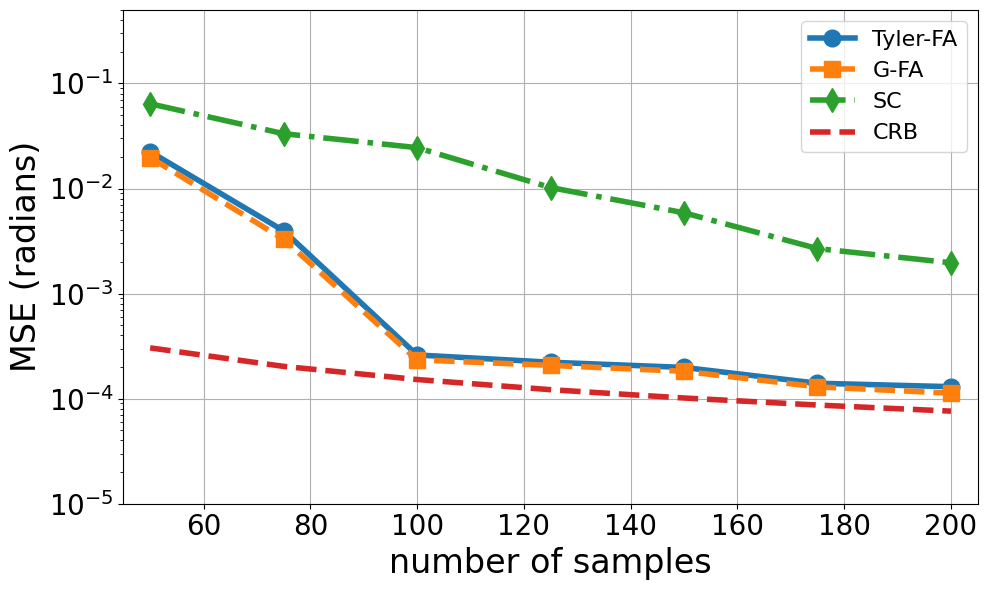

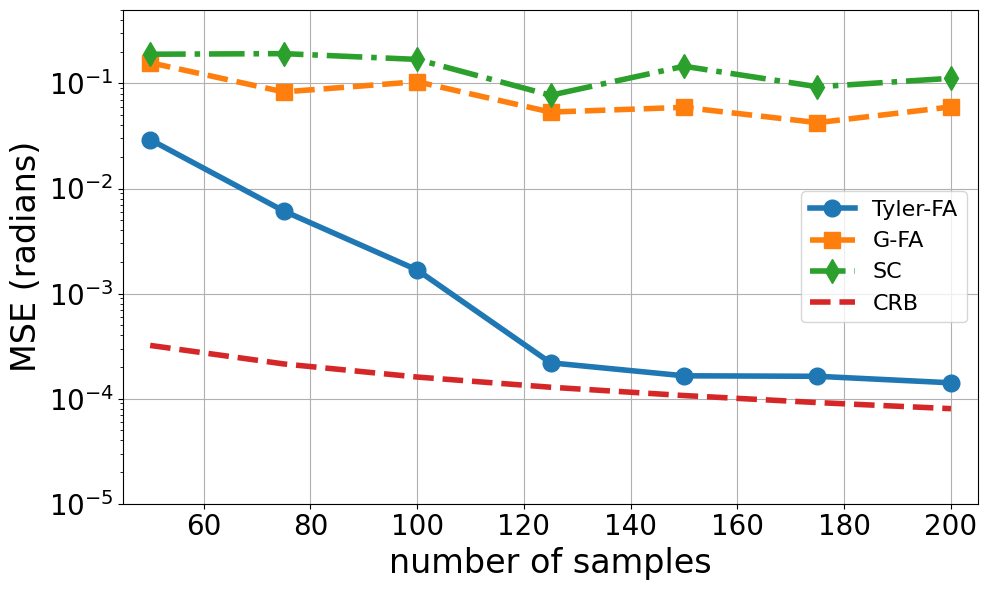

In [8]:
# Create the plot
for distribution in ['N', 'T']:
    fig, ax = plt.subplots(figsize=(10, 6))

    if distribution == "N":
        MSE_Tyler = MSE_Tyler_N
        MSE_G_FA = MSE_G_FA_N 
        MSE_S = MSE_S_N 
        CRB = CRB_N 
    else:
        MSE_Tyler = MSE_Tyler_T
        MSE_G_FA = MSE_G_FA_T
        MSE_S = MSE_S_T
        CRB = CRB_T

    # Plot MSEs with markers and error bars
    ax.semilogy(all_num_of_samples, MSE_Tyler, marker='o', linestyle='-', linewidth=4, markersize=12,  label='Tyler-FA')
    ax.semilogy(all_num_of_samples, MSE_G_FA, marker='s', linestyle='--', linewidth=4, markersize=12, label='G-FA')
    ax.semilogy(all_num_of_samples, MSE_S, marker='d', linestyle='-.', linewidth=4, markersize=12, label='SC')
    ax.semilogy(all_num_of_samples, CRB, linestyle='--', linewidth=4, label='CRB')
    ax.set_xlabel('number of samples', fontsize=24)
    ax.set_ylabel('MSE (radians)', fontsize=24)
    ax.set_xlim(45, 205)
    ax.set_ylim(1e-5, 5*1e-1)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if distribution == "N":
        location = 'upper right'
    else:
        location = 'right' 
    ax.legend(loc=location, fontsize=16)
    ax.grid(True)

    # Ensure tight layout
    plt.tight_layout()

    plt.savefig(f'DOA_distribution={distribution}_CCP_iter={max_iter_CCP}.pdf')

In [9]:
np.savez(f"DOA_data_CCP_iter={max_iter_CCP}.npz", 
         all_errors_Tyler_FA_N=all_errors_Tyler_FA_N, all_errors_S_N=all_errors_S_N, 
         all_errors_G_FA_N = all_errors_G_FA_N, 
         all_errors_Tyler_FA_T=all_errors_Tyler_FA_T, all_errors_S_T=all_errors_S_T, 
         all_errors_G_FA_T = all_errors_G_FA_T, 
         all_num_of_samples=all_num_of_samples,
         theta_rad=theta_rad, noise_variances=noise_variances, 
         num_of_sensors=num_of_sensors, snr=snr, degrees_of_freedom=degrees_of_freedom)